# Part 4 - New data on Weekly Claims

- toc: True
- badges: true
- comments: true
- categories: [jupyter]

I was scanning a WSJ article today on jobless claims, 
https://www.wsj.com/articles/weekly-jobless-claims-coronavirus-10-29-2020-11603921724?modtag=djemBestOfTheWeb
The article started by claiming that initial claims filings had fallen to their lowest level since the pandemic began.
This didn't seem interesting because according to FRED you could have been saying that since May.
Seems like saying I am as old as I've ever been. But then I noticed a chart showing 
claims under Regular state programs *plus* claims under special pandemic programs ... and for continued claims the special pandemic numbers were about the same as the regular ones.  Uh oh, so the claims could be 2x what I would get from FRED and the normal BLS data.  I could not find any data on these new plans on FRED but did find a spreadsheet on the Department of Labor website, see https://oui.doleta.gov/unemploy/DataDashboard.asp

The data might be available on the DOL or BLS site via some API. Not sure yet.
In any case, in this post I will read in that data and plot it.  Later I will figure out how to integreate it with the rest.


In [1]:
import os
import sys
import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
import time
import re
from IPython.display import display
import requests
from PyPDF2 import PdfFileReader
from plotnine import ggplot
import matplotlib as mpl
import xlrd
import matplotlib.pyplot as plt
import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import pathlib
import shutil

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# set the temp directory for downloading data
temp_dir = "./data/temp"
if not os.path.isdir(temp_dir):
    os.mkdir(temp_dir)
prefs = {"download.default_directory" : os.path.abspath(temp_dir)}

options = webdriver.ChromeOptions()
options.add_experimental_option("prefs",prefs)
options.add_argument("download.default_directory="+os.path.abspath(temp_dir))

In [4]:
# function to get filepath of most recently downloaded file
def get_downloaded_fpath(data_dir=None, files_before=None, file_ext=".csv",
                   max_wait = 10, verbosity=0):
    import time
    done = False
    start_time = datetime.datetime.now()
    while not done:
        files_after = set(os.listdir(data_dir))
        new_files = files_after.difference(set(files_before))
        if verbosity > 0:
            print("Files Before: {0}".format(files_before))
            print("Files After: {0}".format(files_after))
            print("New Files: {0}".format(new_files))
        if verbosity > 0:
            print(new_files)
        for fname in new_files:
            if os.path.splitext(fname)[1] == file_ext:
                return (os.path.join(data_dir, fname))
        cur_time = datetime.datetime.now()
        if (cur_time - start_time).seconds > max_wait:
            return None
        time.sleep(0.5)

In [5]:
# use chromedriver to open url
chromedriver_path = os.path.join('chromedriver.exe')
driver = webdriver.Chrome(executable_path=chromedriver_path, options=options)
url = "https://oui.doleta.gov/unemploy/DataDashboard.asp"
driver.get(url)

In [6]:
files_before = set(os.listdir(temp_dir))
time.sleep(1)
el = driver.find_element_by_link_text("Weekly Pandemic Claims Data")
el.click()
downloaded_fpath = get_downloaded_fpath(data_dir=temp_dir, files_before=files_before, file_ext=".xlsx", max_wait=3, verbosity=0)
if not downloaded_fpath:
    raise Exception("No downloaded file found!")

def clean_filename(fpath):
    import re
    head, tail = os.path.split(downloaded_fpath)
    base, ext = os.path.splitext(tail)
    pattern = "(.*)(\(\d*\))"
    match = re.match(pattern, base)
    if  match:
        base = match.group(1).strip()
    new_fname = base + ext    
    return new_fname
  
temp_df = pd.read_excel(downloaded_fpath)
# remove bogus cols
bcols = [c for c  in list(temp_df.columns) if c.startswith("Unnamed")]
print(bcols)
if len(bcols) > 0:
  print("dropping columns {0}".format(bcols))
  temp_df.drop(bcols, axis=1, inplace=True)

display(temp_df.head(2))
data_dir = "./data"
new_fname = clean_filename(downloaded_fpath)
new_fpath = os.path.join(data_dir, new_fname)
print(new_fname)
temp_df.to_csv(new_fpath, index=False)

['Unnamed: 6', 'Unnamed: 7']
dropping columns ['Unnamed: 6', 'Unnamed: 7']


,State,Rptdate,PUA IC,Reflect Date,PUA CC,PEUC CC
0,AL,2020-04-04,0,2020-03-28,0.0,0.0
1,AK,2020-04-04,0,2020-03-28,0.0,0.0


weekly_pandemic_claims.xlsx


## Clean up

In [7]:
if os.path.isfile(new_fpath):
    # stop driver and remove old directory
    driver.quit()
    shutil.rmtree(temp_dir)

## Read 
Read in the spreadsheet and get rid of rows with no data for Rptdate

In [8]:
data_dir = "./data"
new_fpath = os.path.join(data_dir, new_fname)
states_df = pd.read_csv(new_fpath)
states_df = states_df[states_df['Rptdate'].notna()]
states_df.rename(columns={"Rptdate":"date"}, inplace=True)
display(states_df.tail(3))

,State,date,PUA IC,Reflect Date,PUA CC,PEUC CC
4343,WV,2021-10-23,0,NaN,NaN,NaN
4344,WI,2021-10-23,18,NaN,NaN,NaN
4345,WY,2021-10-23,0,NaN,NaN,NaN


In [9]:
# can't remember why I needed thos
# must have encountered non-numeric or object columns in the data
data_cols = [c for c in states_df.columns if re.search("CC|IC", c)]
ocols = []
for col in data_cols:
    if states_df[col].dtype == 'object':
        ocols.append(col)
if not ocols:
    print(f"all the data cols [{data_cols}] are numeric")
else:
    # try to convert object columns to numeric
    numeric_rows = states_df[data_cols].apply(lambda x: pd.Series(x).str.isnumeric(), axis=0).all(axis=1)
    print(f"found {0} non numeric rows".format(states_df.shape[0]-numeric_rows))
    states_df = states_df.loc[numeric_rows]
    print(f"{ocols} are object, should be numeric")
    for col in ocols: 
        states_df[col] = states_df[col].astype(float)

all the data cols [['PUA IC', 'PUA CC', 'PEUC CC']] are numeric


In [10]:
# agg state datta to create US level data
states_df['date'] = pd.to_datetime(states_df['date'])
us_df = states_df.drop(labels=["State"], axis=1).groupby(by='date')
us_df = us_df.sum(min_count=1)
us_df.dropna(how="any", inplace=True)
#us_df.tail()
us_df.to_csv(os.path.join("./data", "us_pau_claims.csv"))

## Plot
For now I'm not interested in the state breakdown so I'll aggregate to US level
and also separte out Initial Claims, IC, from Continued Claims, CC.
Partly because the CC values are about 10x the IC values so easier to see and check the IC data if plotted alone. 
Also because there is data on 2 different special programs for CC.

,date,PUA CC,PEUC CC,CC Tot
76,2021-09-18,1059248.0,991813.0,2051061.0
77,2021-09-25,647690.0,630814.0,1278504.0
78,2021-10-02,549103.0,440435.0,989538.0
79,2021-10-09,517949.0,331567.0,849516.0
80,2021-10-16,270013.0,244379.0,514392.0


Plotting IC
Plotting CC


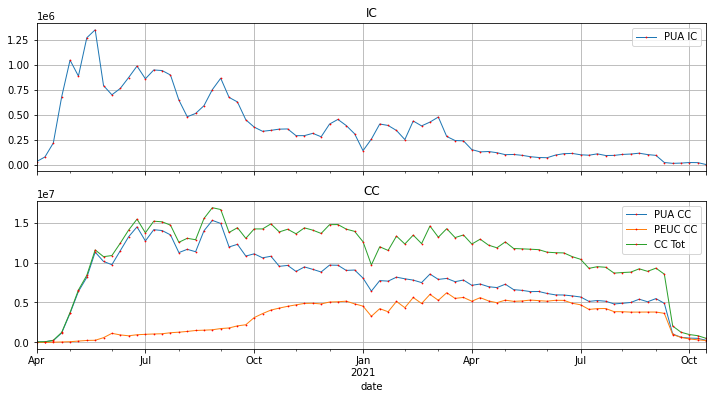

In [11]:
ic_df = us_df[['PUA IC']].reset_index()
cc_df = us_df.drop('PUA IC', axis=1).reset_index()
cc_df['CC Tot'] = cc_df[["PUA CC","PEUC CC"]].sum(axis=1, skipna=False)
display(cc_df.tail())
weekly_dfs = {"IC":ic_df, "CC":cc_df}

figwd = 12
fight= 6
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[figwd, fight], sharex=True)
for i, key in enumerate(weekly_dfs.keys()):
    print(f"Plotting {key}")
    ax = axs[i]
    weekly_dfs[key].plot(ax=ax, x='date',  kind='line', linestyle='-', marker='o', lw=1, title=key,
               mec='red', mfc='black', ms=0.75, legend=True, label=None, grid=True)